# Video embedding using the Barlow Twins method

This notebook applies several augmentations to an input video and implements self-supervised learning using the Barlow Twins method. The data contains two hours of nesting behaviour. 


## 1. Importing the package 

In [1]:
import video_embedding as ve

## 2. Loading the video and applying augmentations

**Note:**
The current model uses the BatchNorm module of pytorch. This only allows for batch sizes larger than 1. Users should use LayerNorm for batch sizes of 1.

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
batch_size = 2

image_size = 216
duration = 16 #30
clip_size = 30 #90
num_workers = 1


video_list = ["example_video.mp4"]
print(len(video_list))

augmentator = ve.VideoAugmentator(duration=duration, crop_size=image_size, multiplier=6)
dataset = ve.VidioDataset(video_list, augmentator, clip_size, temporal_downsample=2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

1


C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
import numpy as np
x_one, x_two = next(iter(dataloader))
x_one = ve.untransform_video(x_one)
x_two = ve.untransform_video(x_two)
ve.play_videos(np.concatenate([x_one[:4],x_two[:4]]), 2, 4)

## 3.Training the model

**Note:**  This notebook uses the variable `device = "cuda"` for running code on an NVIDIA GPU. If your computer does NOT have an NVIDIA GPU: Change **all** instances of `"cuda"` in the code to `"cpu"`. Training and inference will still work, but may be much slower on CPU.

In [3]:
model, feature_size = ve.get_model("s3d")
learner = ve.BarlowTwins(model, feature_size).to('cpu').train()
opt = torch.optim.Adam(learner.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

In [68]:
ve.train(
    learner=learner,
    model=model,
    optimizer=opt,
    scheduler=scheduler,
    dataloader=dataloader,
    start_epoch=0,
    epochs=10,
    steps_per_epoch=10,
    checkpoint_dir= 'checkpoint_dir',
    loss_log_path= 'loss_log.txt',
    device='cpu'
)

Epoch 10/10: 100%|████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.85s/batch, loss=1.05e+3]


In [ ]:
# To resume training from a checkpoint, uncomment this cell

#checkpoint_path = './checkpoint_directory/checkpoint_3.pth'
#learner, scheduler, opt, model, epoch = ve.load_from_checkpoint(
#checkpoint_path, model, learner, opt, scheduler
#)
#start_epoch = epoch + 1
#ve.train(
#    learner=learner,
#  model=model,
#    optimizer=opt,
#    scheduler=scheduler,
#    dataloader=dataloader,
#    start_epoch=epoch +1,
#    epochs=3,0
#    steps_per_epoch=10,
#    checkpoint_dir= 'checkpoint_dir',
#    loss_log_path= 'loss_log.txt',
#    device='cpu'
#)

## 4.Inspecting model 

### 4.1 Training loss curve 

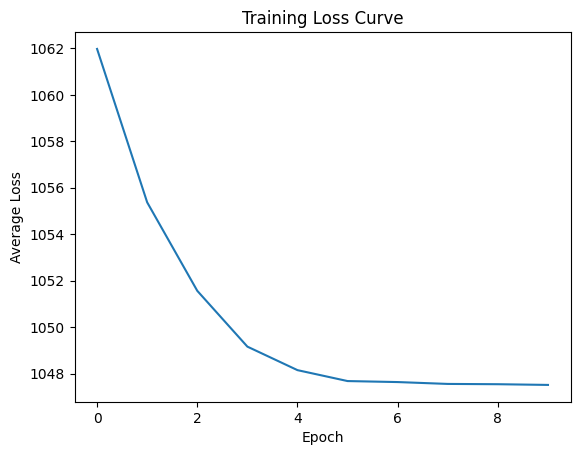

In [86]:
import matplotlib.pyplot as plt

plt.plot(np.loadtxt(loss_log, delimiter="\t")[:,1])
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.grid(False)
plt.show()

In [88]:
import glob 
from vidio.read import OpenCVReader
#video_paths = ['/Users/User/Desktop/video-embedding/example_video.mp4']
video_paths = ['example_video.mp4']
lengths = [len(OpenCVReader(p)) for p in video_paths]

[216299]


In [67]:
import tqdm
import numpy as np
paths = []
starts = []
embeddings = []

for i in tqdm.trange(500):
    ix = np.random.choice(len(video_paths))
    path = video_paths[ix]
    start = np.random.randint(lengths[ix]-60)
    clip = ve.get_clip(path, start, duration=60)[::2]
    clip = ve.center_crop(clip, image_size)
    X = ve.transform_video(clip)[None]
    embedding = model(X.to("cpu"))
    embeddings.append(embedding.detach().cpu().numpy()[0])
    starts.append(start)
    paths.append(path)

import joblib
embeddings = np.array(embeddings)
joblib.dump((paths, starts, embeddings), 'videoclips.p')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [12:37<00:00,  1.51s/it]


['videoclips.p']

In [14]:
from umap import UMAP
from sklearn.decomposition import PCA

Xpca = PCA(n_components=20).fit_transform(embeddings)
xy = UMAP(n_components=2, n_neighbors=50).fit_transform(embeddings)

C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [44]:
# xy_emb = xy
# Xpca_emp = Xpca

In [99]:
from sklearn.cluster import KMeans

n_clusters = 8
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

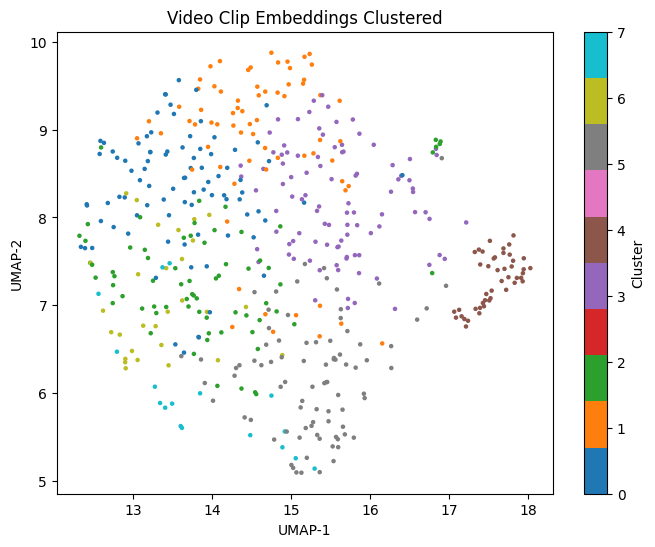

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(xy[:,0], xy[:,1], c=clus, cmap='tab10', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title('Video Clip Embeddings Clustered')
plt.show()


In [98]:
n_examples_per_cluster = 4

clips = []
for i in range(n_clusters):
    ixs = np.random.choice((clus==i).nonzero()[0], n_examples_per_cluster, replace=False)
    for ii in ixs:
        clips.append(ve.get_clip(paths[ii], starts[ii], duration=60)[::2])
ve.play_videos(np.stack(clips), n_clusters, n_examples_per_cluster)

In [101]:
from sklearn.cluster import KMeans

n_clusters = 16
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

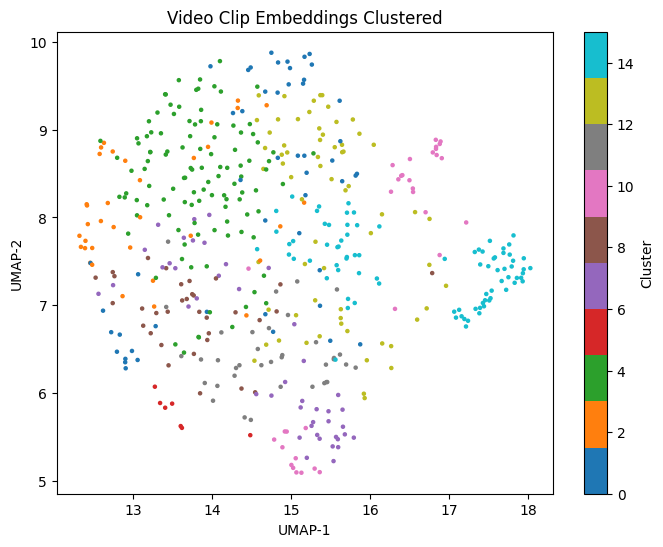

In [104]:
plt.figure(figsize=(8,6))
plt.scatter(xy[:,0], xy[:,1], c=clus, cmap='tab10', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title('Video Clip Embeddings Clustered')
plt.show()

In [103]:
o = np.argsort(np.argsort([np.array(starts)[clus==i].mean() for i in range(n_clusters)]))
clus = o[clus]

In [38]:
n_examples_per_cluster = 4

clips = []
for i in range(n_clusters):
    ixs = np.random.choice((clus==i).nonzero()[0], n_examples_per_cluster, replace=False)
    for ii in ixs:
        clips.append(ve.get_clip(paths[ii], starts[ii], duration=60)[::2])
ve.play_videos(np.stack(clips), n_clusters, n_examples_per_cluster)

In [71]:
from torchvision import models

checkpoint_dir='checkpoint_dir'

model = models.video.s3d(weights=models.video.S3D_Weights.DEFAULT)
model.classifier = torch.nn.Identity()
model = model.to("cpu").eval()

image_size = 216
feature_size = 1024
loss_log = os.path.join(checkpoint_dir, "log_loss.txt")